In [1]:
import numpy as np
import pandas as pd
from numba import jit

@jit
def jaccard(m1, m2):

    k1min = min(m1)
    k1max = max(m1)
    k2min = min(m2)
    k2max = max(m2)

    k1 = k1max - k1min + 1
    k2 = k2max - k2min + 1
    tab = np.zeros((k1,k2), dtype=np.uint32)

    for i in range(len(m1)):
        tab[(m1[i]-k1min),(m2[i]-k2min)] += 1
    dotp0 = np.sum(tab*(tab-1))
    tab1 = np.sum(tab, axis=1)
    tab2 = np.sum(tab, axis=0)
    dotp1 = np.sum(tab1*(tab1-1))
    dotp2 = np.sum(tab2*(tab2-1))

    return dotp0/(dotp1+dotp2-dotp0)

@jit
def matching(m1, m2):

    k1min = min(m1)
    k1max = max(m1)
    k2min = min(m2)
    k2max = max(m2)

    k1 = k1max - k1min + 1
    k2 = k2max - k2min + 1
    tab = np.zeros((k1,k2), dtype=np.uint32)

    for i in range(len(m1)):
        tab[(m1[i]-k1min),(m2[i]-k2min)] += 1
    dotp0 = np.sum(tab*(tab-1))
    tab1 = np.sum(tab, axis=1)
    tab2 = np.sum(tab, axis=0)
    dotp1 = np.sum(tab1*(tab1-1))
    dotp2 = np.sum(tab2*(tab2-1))

    n = len(m1)
    return 1 - (dotp1 - 2*dotp0 + dotp2)/(n**2)

@jit
def cosine(m1, m2):

    k1min = min(m1)
    k1max = max(m1)
    k2min = min(m2)
    k2max = max(m2)

    k1 = k1max - k1min + 1
    k2 = k2max - k2min + 1
    tab = np.zeros((k1,k2), dtype=np.uint32)

    for i in range(len(m1)):
        tab[(m1[i]-k1min),(m2[i]-k2min)] += 1
    tab1 = np.sum(tab, axis=1)
    tab2 = np.sum(tab, axis=0)
    dotp0 = np.sum(tab*(tab-1))
    dotp1 = np.sum(tab1*(tab1-1))
    dotp2 = np.sum(tab2*(tab2-1))

    return dotp0/np.sqrt(dotp1*dotp2)

In [2]:
# read in lotla miami data
lmdi_plus_miami = np.loadtxt("../lfi-values/seed0/361260/" + \
    "elastic_nonnormed_nosquared_norank.csv", delimiter=",")
cols_miami = ['LATITUDE', 'LONGITUDE', 'LND_SQFOOT', 'TOT_LVG_AREA',
              'SPEC_FEAT_VAL', 'RAIL_DIST', 'OCEAN_DIST', 'WATER_DIST',
              'CNTR_DIST', 'SUBCNTR_DI', 'HWY_DIST', 'age', 'avno60plus',
              'month_sold', 'structure_quality']

In [3]:
# read in shap and lime miami data
shap_miami = np.loadtxt("../lfi-values/seed0/361260/" + \
    "shap.csv", delimiter=",")
lime_miami = np.loadtxt("../lfi-values/seed0/361260/" + \
    "lime.csv", delimiter=",")

In [4]:
# add ID column
lmdi_plus_miami = np.insert(lmdi_plus_miami, 0, np.arange(1, lmdi_plus_miami.shape[0] + 1), axis=1)
shap_miami = np.insert(shap_miami, 0, np.arange(1, shap_miami.shape[0] + 1), axis=1)
lime_miami = np.insert(lime_miami, 0, np.arange(1, lime_miami.shape[0] + 1), axis=1)

In [5]:
lmdi_plus_miami = pd.DataFrame(lmdi_plus_miami, columns=["ID"] + cols_miami)
shap_miami = pd.DataFrame(shap_miami, columns=["ID"] + cols_miami)
lime_miami = pd.DataFrame(lime_miami, columns=["ID"] + cols_miami)

In [6]:
# import kmeans
from sklearn.cluster import KMeans

In [7]:
def algorithm1(k, m, data, similarity_func):
    """
    Computes the clustering similarities using k-means.
    
    Args:
        k (int): Number of clusters
        m (float): Proportion of data
        data (pd.DataFrame): lotla data with at least an 'ID' column
        similarity_func (function): Similarity function to use
    
    Returns:
        np.ndarray: A vector of similarity scores
    """
    np.random.seed(0)
    
    num_rows, num_cols = data.shape
    
    N = 100  # Number of repetitions
    jaccard_vector = np.full(N, np.nan)  # Initialize similarity vector with NaNs
    
    for i in range(N):
        # Sample data
        idx1 = np.random.choice(num_rows, int(num_rows * m), replace=False)
        idx2 = np.random.choice(num_rows, int(num_rows * m), replace=False)
        
        # Get subsets
        sub1 = data.iloc[idx1].copy()
        sub2 = data.iloc[idx2].copy()
        
        # print(type(sub1))
        # print(sub1.columns)
        
        # Perform k-means clustering on the subsets (assuming columns start from index 6)
        kmeans1 = KMeans(n_clusters=k, random_state=0)
        kmeans2 = KMeans(n_clusters=k, random_state=0)
        
        # cluster on everything except the ID column        
        sub1_clusters = kmeans1.fit_predict(sub1.iloc[:, 1:num_cols])  
        sub2_clusters = kmeans2.fit_predict(sub2.iloc[:, 1:num_cols]) 
        
        # Assign the cluster labels to the data by creating new columns        
        sub1['cluster1'] = sub1_clusters
        sub2['cluster2'] = sub2_clusters
        
        # Perform an inner join based on 'ID' (assuming 'ID' column exists in the data)
        sub_intersect = pd.merge(sub1[['ID', 'cluster1']], sub2[['ID', 'cluster2']], on='ID')
        
        # Calculate Jaccard similarity
        jaccard_score = similarity_func(sub_intersect['cluster1'].to_numpy(),
                                        sub_intersect['cluster2'].to_numpy())
        
        jaccard_vector[i] = jaccard_score
    
    return jaccard_vector


In [8]:
from joblib import Parallel, delayed

In [9]:
# run algorithm1 in parallel for k=2,...,10
jaccard_scores_lmdi_plus = Parallel(n_jobs=-1)(delayed(algorithm1)(k, 0.8, lmdi_plus_miami, jaccard) for k in range(2, 11))
jaccard_scores_shap = Parallel(n_jobs=-1)(delayed(algorithm1)(k, 0.8, shap_miami, jaccard) for k in range(2, 11))
jaccard_scores_lime = Parallel(n_jobs=-1)(delayed(algorithm1)(k, 0.8, lime_miami, jaccard) for k in range(2, 11))

In [10]:
# run algorithm1 in parallel for k=2,...,10
matching_scores_lmdi_plus = Parallel(n_jobs=-1)(delayed(algorithm1)(k, 0.8, lmdi_plus_miami, matching) for k in range(2, 11))
matching_scores_shap = Parallel(n_jobs=-1)(delayed(algorithm1)(k, 0.8, shap_miami, matching) for k in range(2, 11))
matching_scores_lime = Parallel(n_jobs=-1)(delayed(algorithm1)(k, 0.8, lime_miami, matching) for k in range(2, 11))

In [11]:
cluster_jaccards_lmdi_plus = {k: jaccard_scores_lmdi_plus[k-2] for k in range(2, 11)}
cluster_jaccards_shap = {k: jaccard_scores_shap[k-2] for k in range(2, 11)}
cluster_jaccards_lime = {k: jaccard_scores_lime[k-2] for k in range(2, 11)}

In [12]:
cluster_matchings_lmdi_plus = {k: matching_scores_lmdi_plus[k-2] for k in range(2, 11)}
cluster_matchings_shap = {k: matching_scores_shap[k-2] for k in range(2, 11)}
cluster_matchings_lime = {k: matching_scores_lime[k-2] for k in range(2, 11)}

lmdi_plus


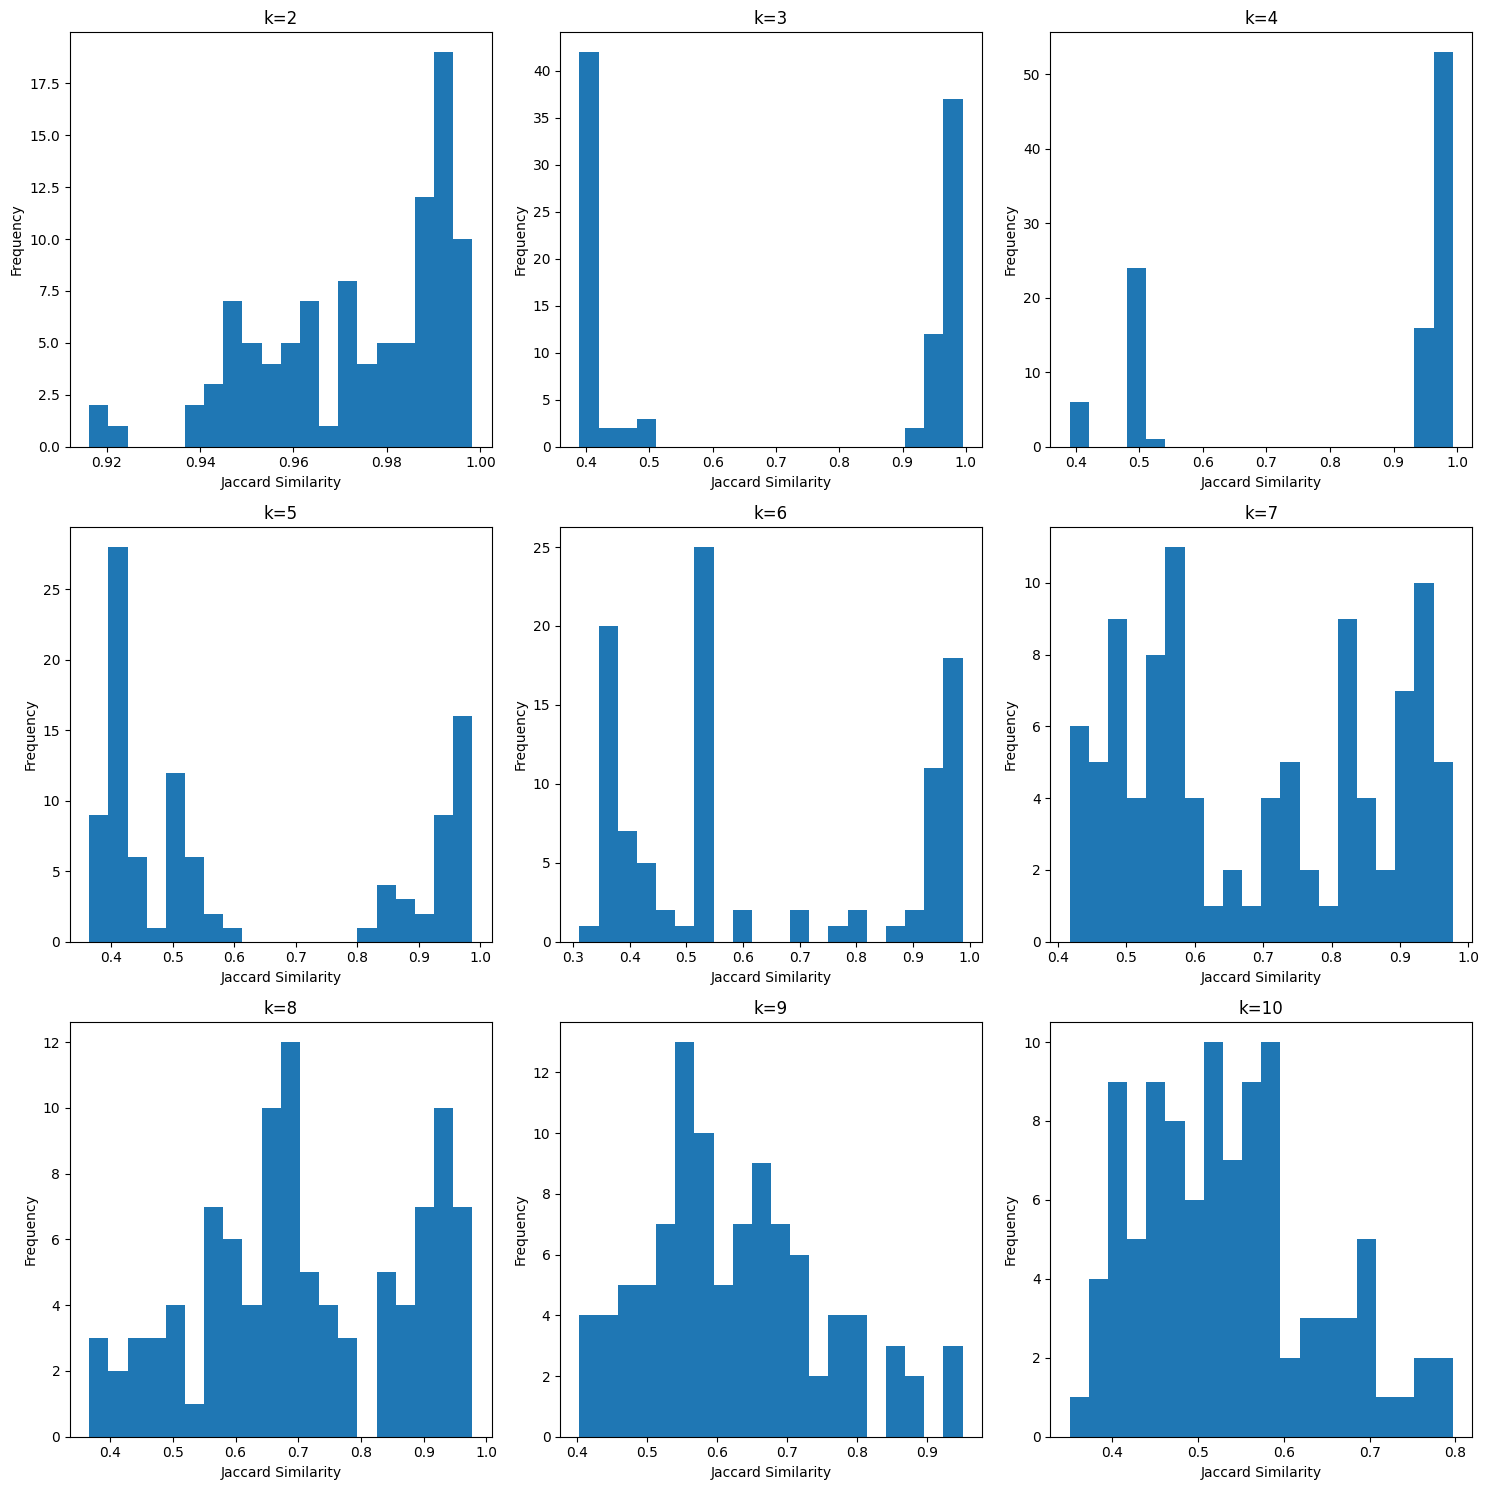

shap


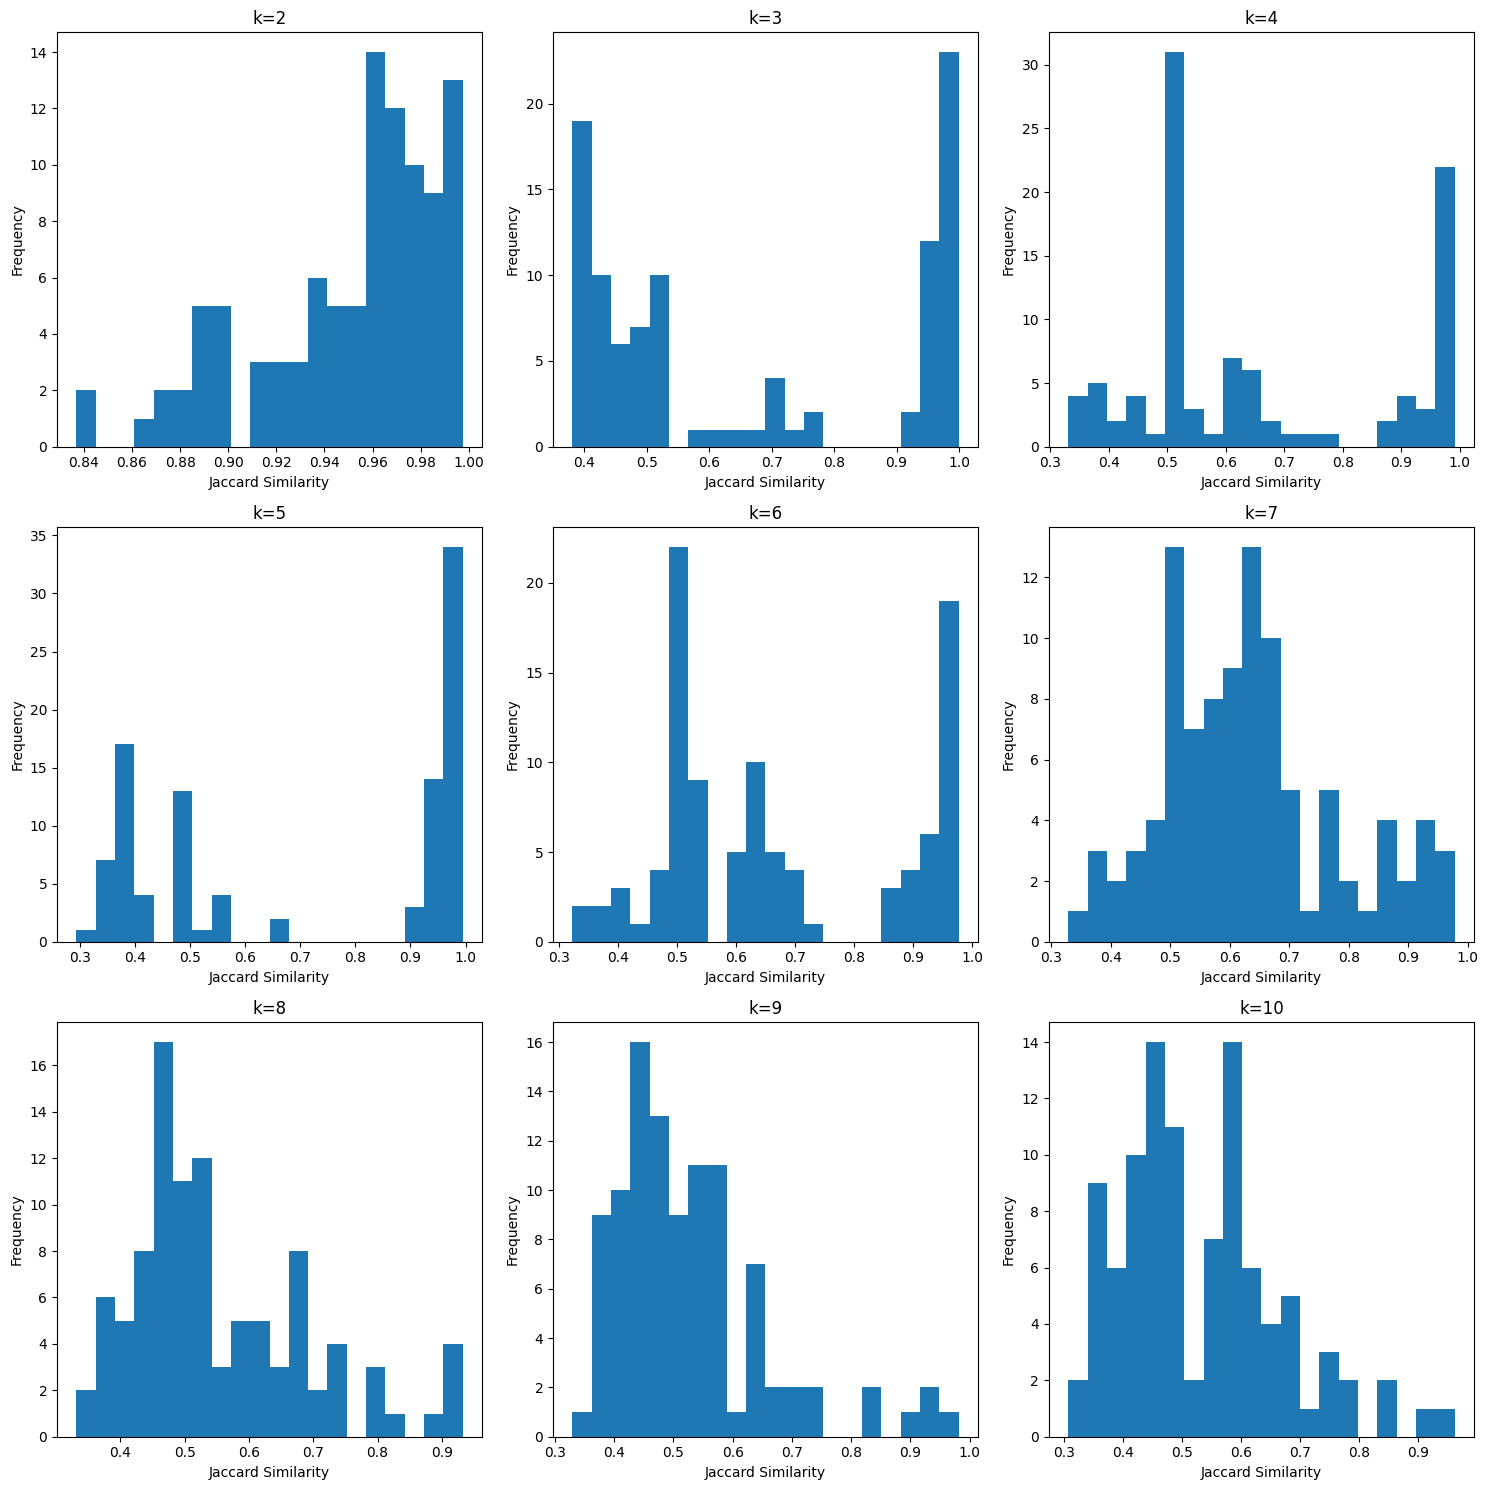

lime


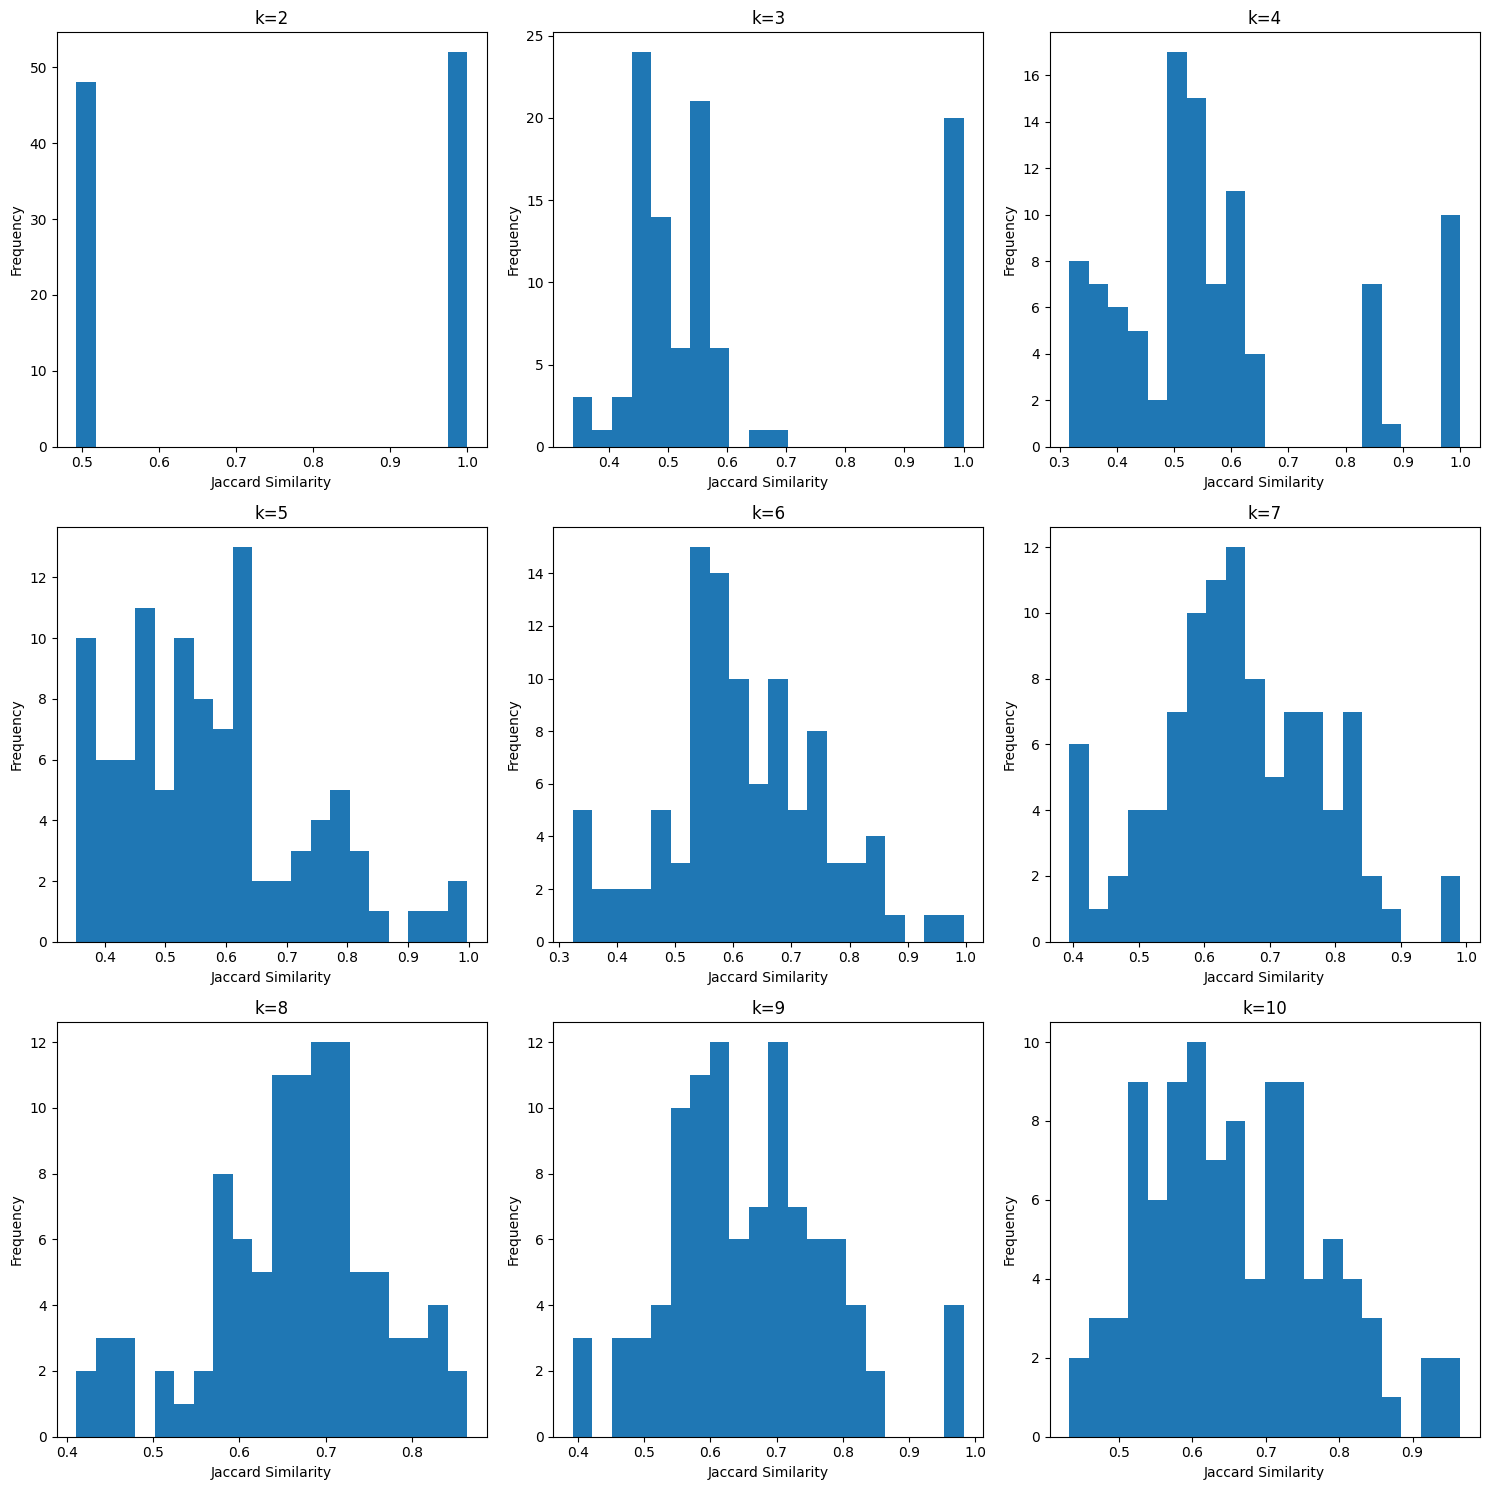

In [13]:
# make a histogram of the scores for each k
import matplotlib.pyplot as plt

lfi_type = ["lmdi_plus", "shap", "lime"]
j=0
for cluster_jaccards in [cluster_jaccards_lmdi_plus, cluster_jaccards_shap, cluster_jaccards_lime]:
    print(lfi_type[j])

    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    axs = axs.ravel()

    for i, (k, scores) in enumerate(cluster_jaccards.items()):
        axs[i].hist(scores, bins=20)
        axs[i].set_title(f"k={k}")
        axs[i].set_xlabel("Jaccard Similarity")
        axs[i].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()
    j += 1


lmdi_plus


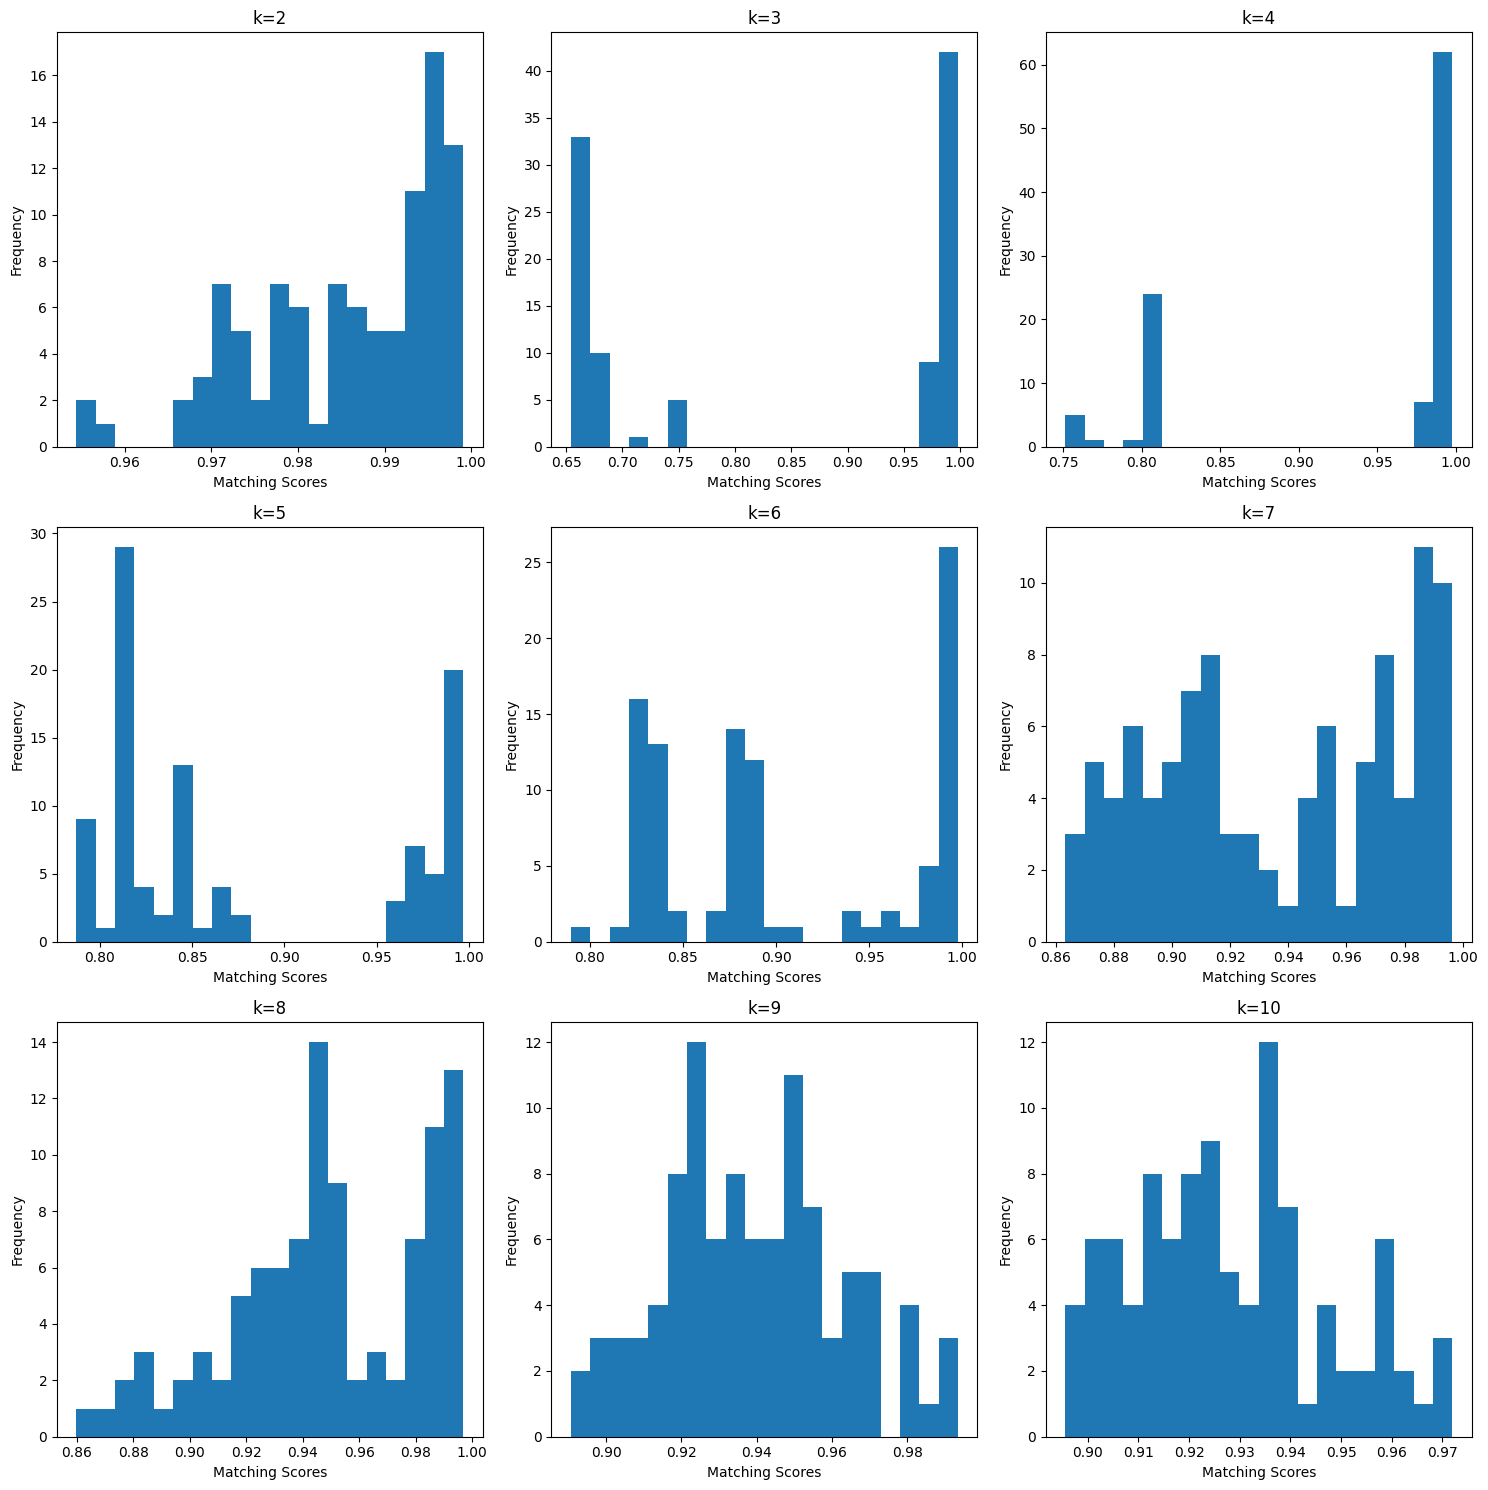

shap


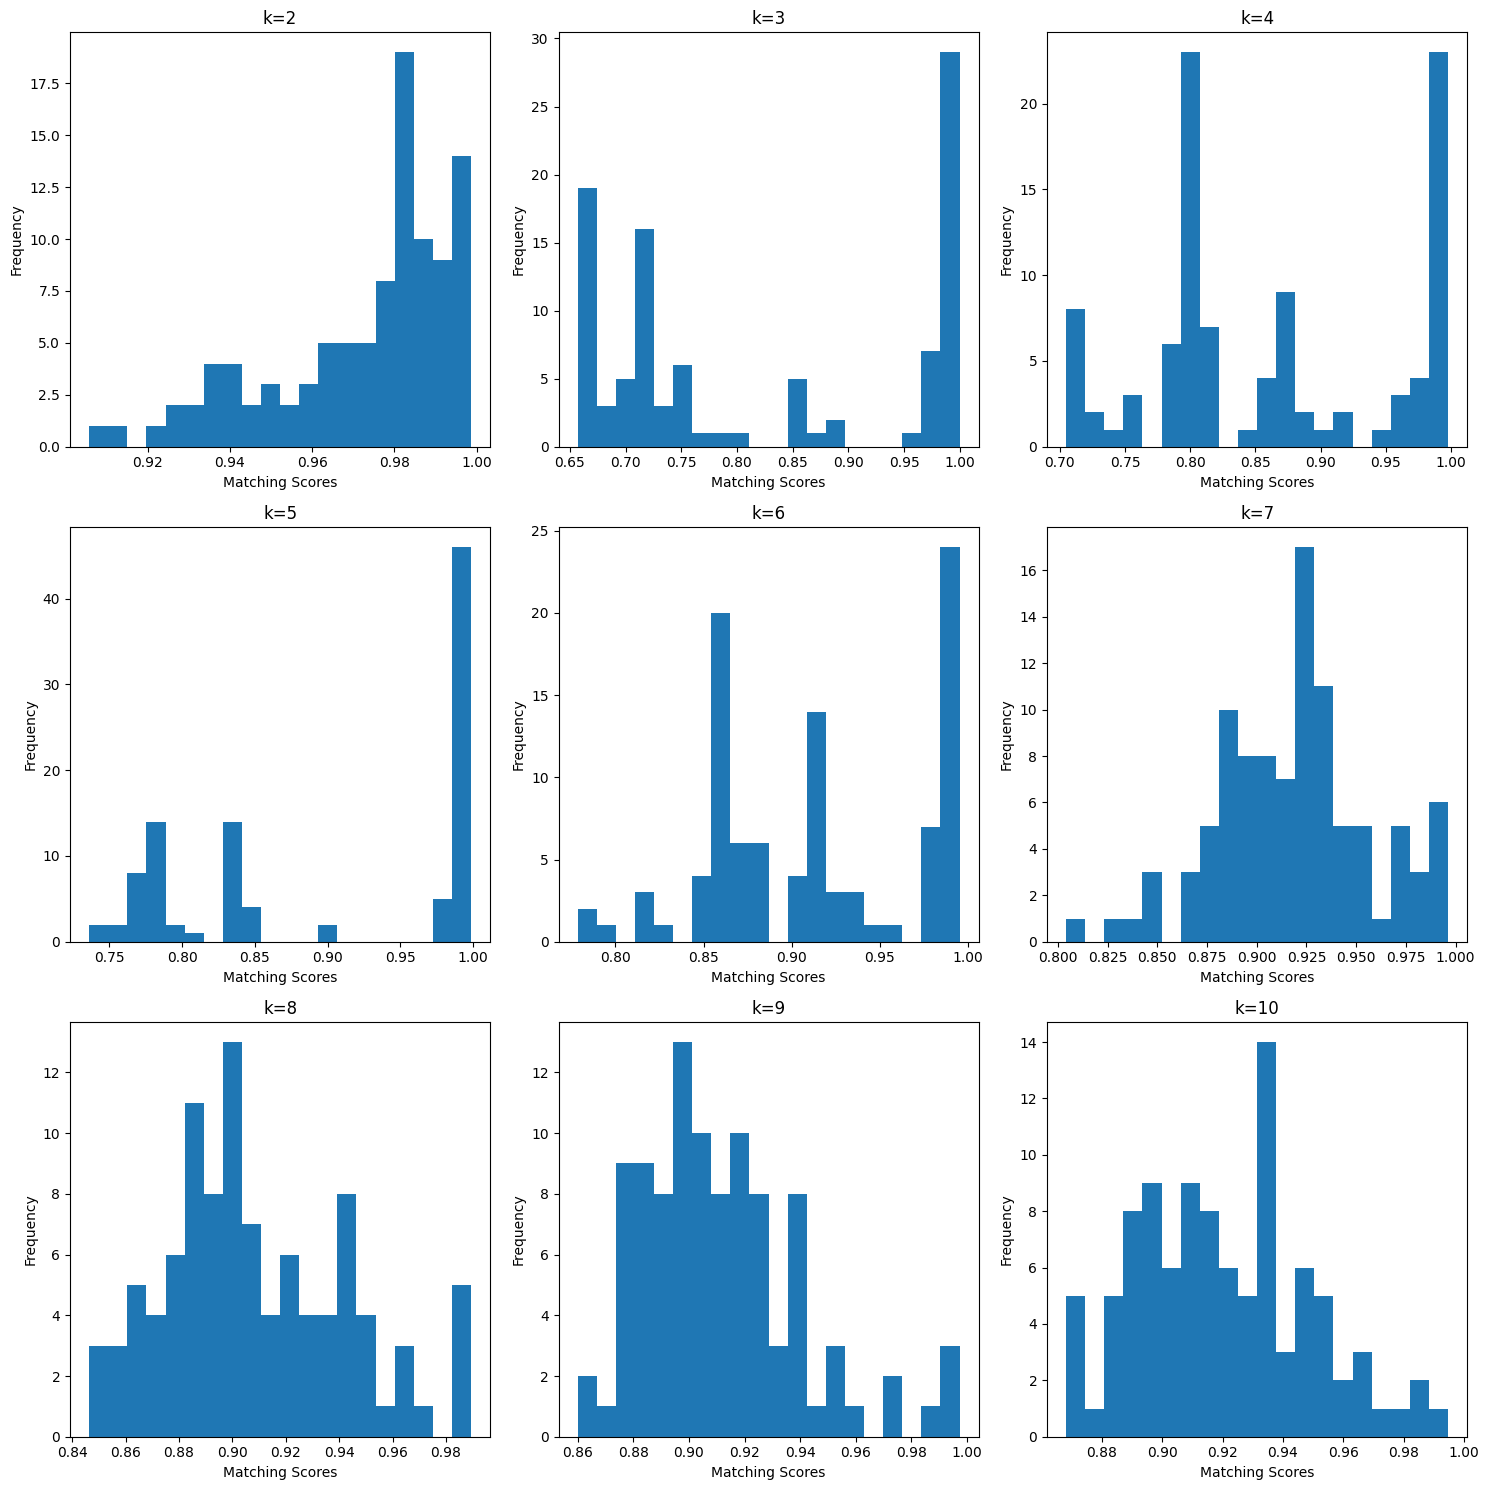

lime


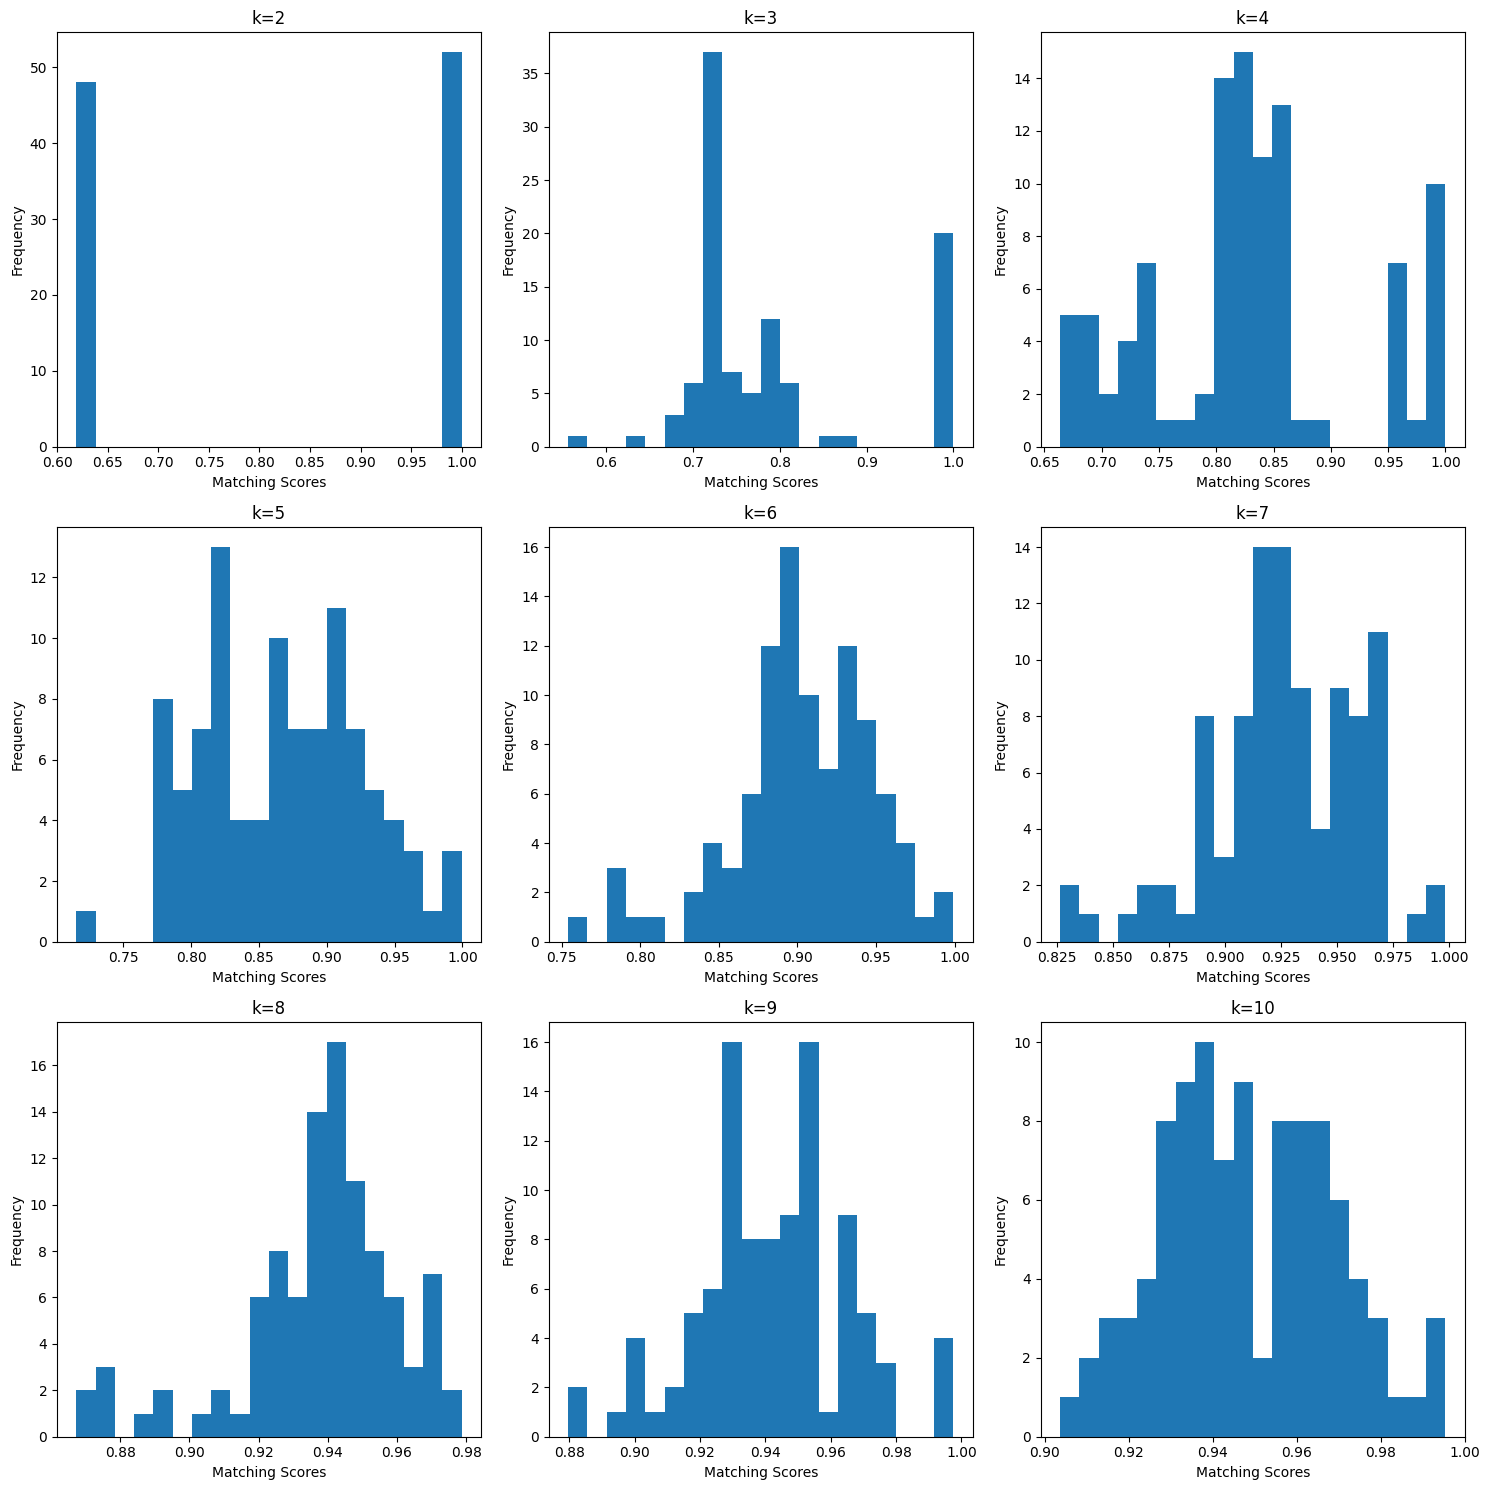

In [14]:
# make a histogram of the scores for each k
import matplotlib.pyplot as plt
j=0
for cluster_matchings in [cluster_matchings_lmdi_plus, cluster_matchings_shap, cluster_matchings_lime]:
    
    print(lfi_type[j])    

    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    axs = axs.ravel()

    for i, (k, scores) in enumerate(cluster_matchings.items()):
        axs[i].hist(scores, bins=20)
        axs[i].set_title(f"k={k}")
        axs[i].set_xlabel("Matching Scores")
        axs[i].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()
    j += 1


lmdi_plus


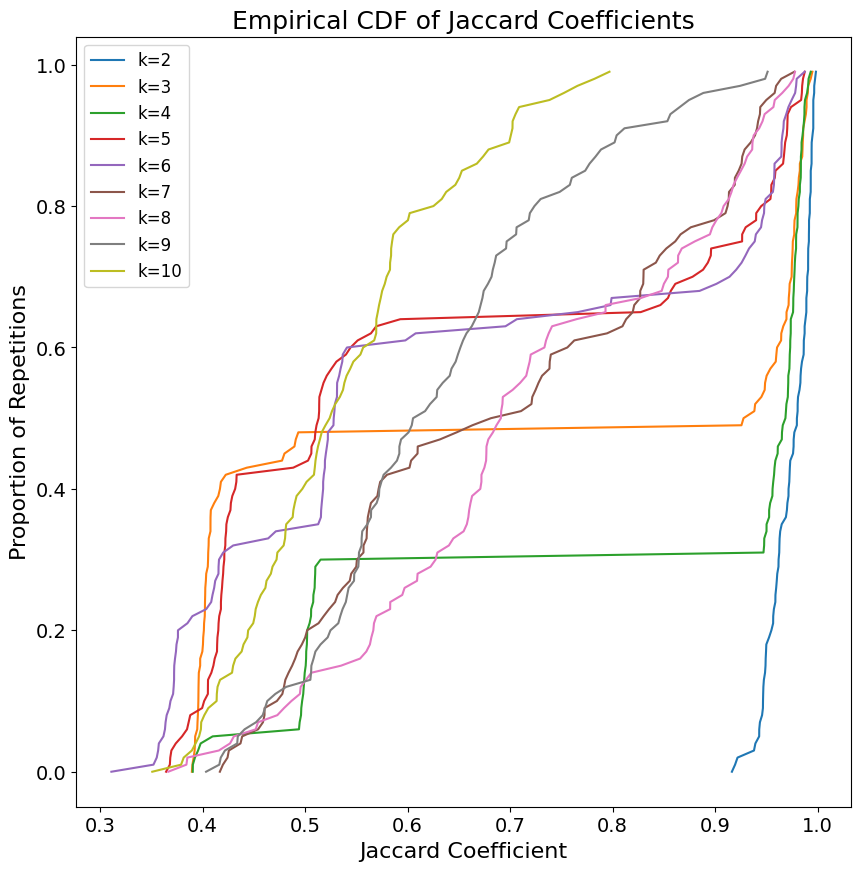

shap


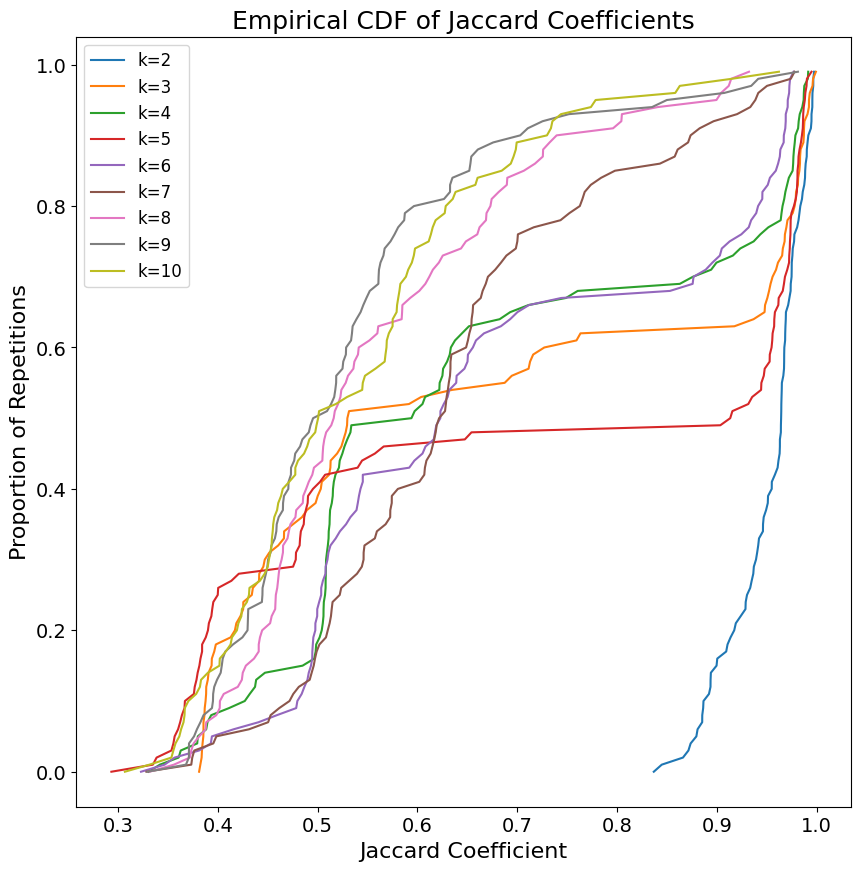

lime


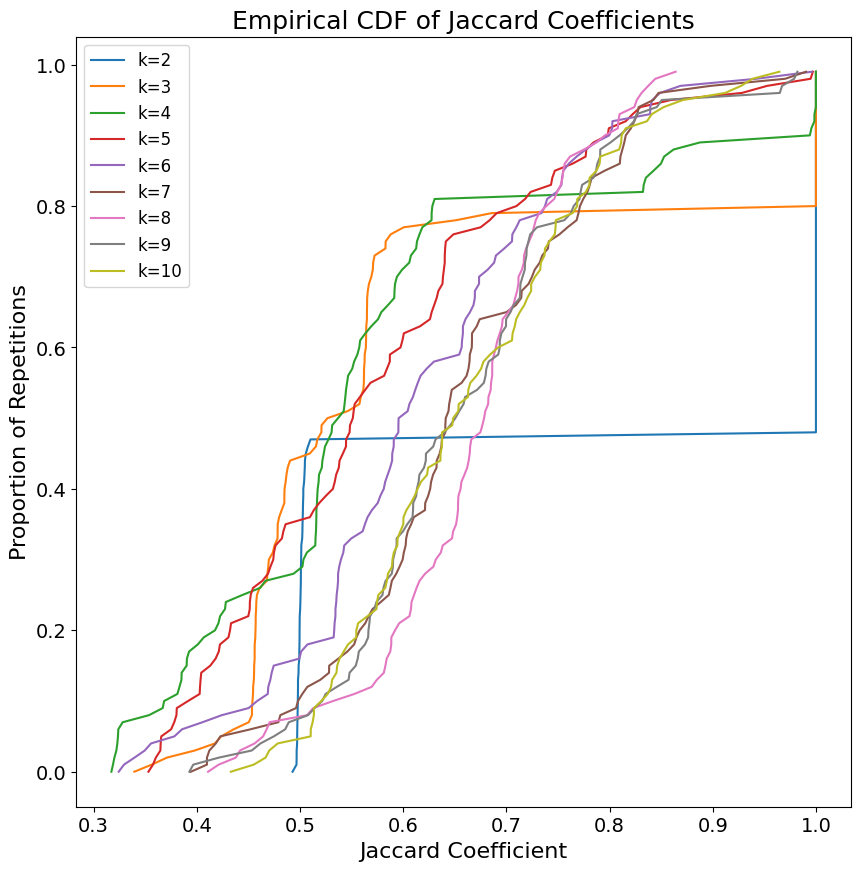

In [15]:
# plot the CDF of the jaccard coefficients, where each color is a different k
j=0
for cluster_jaccards in [cluster_jaccards_lmdi_plus, cluster_jaccards_shap, cluster_jaccards_lime]:
    print(lfi_type[j])

    fig, ax = plt.subplots(figsize=(10, 10))

    for k, scores in cluster_jaccards.items():
        scores = np.sort(scores)
        yvals = np.arange(len(scores))/float(len(scores))
        ax.plot(scores, yvals, label=f"k={k}")

    ax.set_title("Empirical CDF of Jaccard Coefficients", size = 18)
    ax.set_xlabel("Jaccard Coefficient", size=16)
    ax.set_ylabel("Proportion of Repetitions", size=16)
    # make the axis labels bigger
    ax.tick_params(axis='both', which='major', labelsize=14)
    # make legend text bigger
    ax.legend(prop={'size': 12})
    # ax.legend()
    plt.show()
    j+=1